# Import Dependencies

In [1]:
# Plotting Tools
%matplotlib inline
import matplotlib.pyplot as plt

# data preprocessing
import pandas as pd
import numpy as np
import re

# DF formatting options
pd.options.display.max_colwidth = 165

#### Load and explore raw data

In [2]:
raw_data = 'resources/mbti_1.csv'
df = pd.read_csv(raw_data)

In [3]:
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watc...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently ...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely posit..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arb..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


#### Group data to determine distribution of personality types

In [5]:
group_data = df.groupby('type').count()
group_data.sort_values('posts', ascending=False, inplace=True)
print('Personality Types', group_data.index.values)

Personality Types ['INFP' 'INFJ' 'INTP' 'INTJ' 'ENTP' 'ENFP' 'ISTP' 'ISFP' 'ENTJ' 'ISTJ'
 'ENFJ' 'ISFJ' 'ESTP' 'ESFP' 'ESFJ' 'ESTJ']


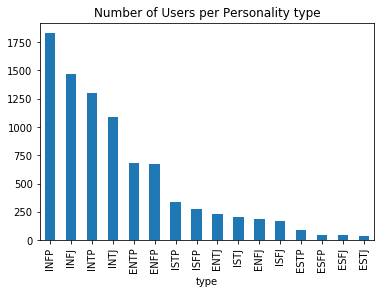

In [6]:
# Distribution of personality types
group_data["posts"].plot(kind="bar", title="Number of Users per Personality type");

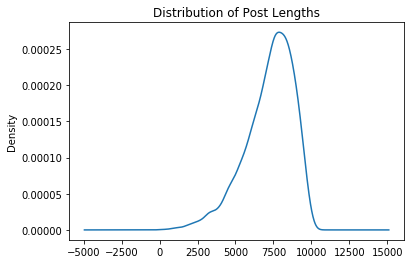

In [7]:
# Distribution of post character length
df['Length_Preprocessed'] = df['posts'].apply(len)
df['Length_Preprocessed'].plot.density().set_title('Distribution of Post Lengths');

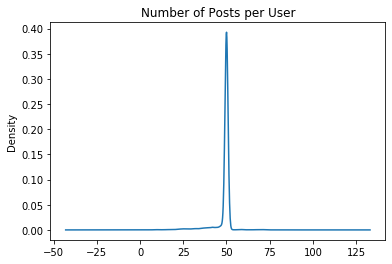

In [8]:
# Distribution of # of posts per user
df["NumPosts"] = df["posts"].apply(lambda x: len(x.split("|||")))
df['NumPosts'].plot.density().set_title('Number of Posts per User');

# Clean and preprocess data

#### define functions

In [9]:
# Split grouped posts into indiv. rows
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))

df = pd.DataFrame(posts, columns=["type", "posts"])

Number of users 8675
Number of posts 422845


In [10]:
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
2,INFJ,enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks
3,INFJ,What has been the most life-changing experience in your life?
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.
...,...,...
422840,INFP,"I was going to close my facebook a few months back, but as well as wanting to be able to message my family in ausse and school friends i found that i had connect..."
422841,INFP,30 Seconds to Mars - All of my collections. It seems to be fitting my mood right now.
422842,INFP,"I have seen it, and i agree. I did actually think that the first time I watched the movie, and from the beginning (or when they got their powers) I kinda thought..."
422843,INFP,"Ok so i have just watched Underworld 4 (Awakening) and must say it was a really good film, Compared to the other films out in the last few months anyway. I don't..."


In [11]:
def preprocess_text(df, mbpt_token=True):
    # Remove url links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
       
    # Strip misc punctuation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    # Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    # Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    # Remove short/long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,2})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    # Remove Personality Type identifiers/tokens from posts 
    # MBPT identifier is subsituted with 'PtypeToken' to avoid bias when training model
    if mbpt_token:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["posts"] = df["posts"].apply(lambda x: p.sub(' PtypeToken ',x))
    return df

In [12]:
# Preprocess Text
clean_data = preprocess_text(df) 

In [13]:
clean_data

,type,posts
0,INFJ,
1,INFJ,
2,INFJ,PtypeToken and PtypeToken moments sportscenter not top ten plays pranks
3,INFJ,What has been the most lifechanging experience your life
4,INFJ,repeat for most today
...,...,...
422840,INFP,was going close facebook few months back but well wanting able message family ausse and school friends found that had connected few other websites
422841,INFP,Seconds Mars All collections seems fitting mood right now
422842,INFP,have seen and agree did actually think that the first time watched the movie and from the beginning when they got their powers kinda thought Andrew would ...
422843,INFP,have just watched Underworld Awakening and must say was really good film Compared the other films out the last few months anyway dont think was good ...


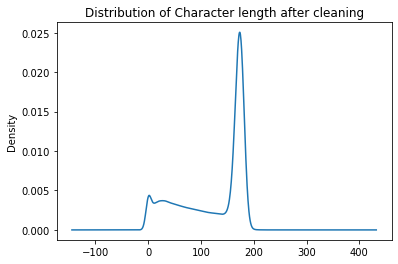

In [14]:
# Distribution of Character length after cleaning
clean_data["Len"] = clean_data["posts"].apply(len)
clean_data["Len"].plot.density().set_title('Distribution of Character length after cleaning');

In [15]:
# Remove posts with less than X words
min_words = 15
print("Number of posts", len(clean_data)) 
clean_data["nw"] = clean_data["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
clean_data = clean_data[clean_data["nw"] >= min_words]
print("Number of posts", len(clean_data)) 

Number of posts 422845
Number of posts 283792


In [16]:
# Remove long post
max_length = 350
print("Number of posts", len(clean_data)) 
clean_data = clean_data[clean_data["Len"] < 350]
print("Number of posts", len(clean_data)) 

Number of posts 283792
Number of posts 283792


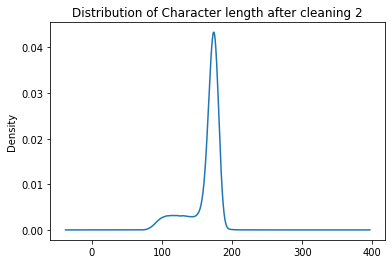

In [17]:
clean_data["Len"] = clean_data["posts"].apply(len)
clean_data["Len"].plot.density().set_title('Distribution of Character length after cleaning 2');

### Cleaned DataFrame

In [18]:
clean_df = pd.DataFrame(clean_data, columns=["type", "posts"])
clean_df.index.names = ['id']
clean_df

,type,posts
id,,
6,INFJ,The last thing INFJ friend posted his facebook before committing suicide the next day Rest peace
7,INFJ,Hello ENFJ Sorry hear your distress Its only natural for relationship not perfection all the time every moment existence Try figure the hard times times...
11,INFJ,Prozac wellbrutin least thirty minutes moving your legs and dont mean moving them while sitting your same desk chair weed moderation maybe try edibles hea...
12,INFJ,Basically come with three items youve determined that each type whichever types you want would more than likely use given each types cognitive functions and ...
13,INFJ,All things moderation Sims indeed video game and good one that Note good one that somewhat subjective that not completely promoting the death any gi...
...,...,...
422839,INFP,Tonight sit outside window the blackness night staring out into the wilderness call space Peace Beauty could stay here till the morning light The thousands...
422840,INFP,was going close facebook few months back but well wanting able message family ausse and school friends found that had connected few other websites
422842,INFP,have seen and agree did actually think that the first time watched the movie and from the beginning when they got their powers kinda thought Andrew would ...


In [20]:
# Export cleaned dataframe to file
clean_df.to_csv('resources/mbti_clean.csv', index = False)

## Creating SQLite Database

In [20]:
# loading in modules
import sqlite3

In [21]:
connection = sqlite3.connect('mbti_final1.db')
cursor = connection.cursor()

## Write data to SQLite Table

In [22]:
# Write df to db
clean_df.to_sql(con=connection, name='data1', if_exists='append', index=False)

## Read in SQLite Tables

In [23]:
# reading all table names using for loop
table_list = [a for a in cursor.execute("SELECT * FROM data1")]
# here is you table list
print(table_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# Same as above, except using cursor.fetchall() method.
cursor.execute('SELECT * FROM data1')
print(cursor.fetchall())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Close the SQLite Connection

In [26]:
# Be sure to close the connection
connection.close()